7. Analice si no hay sobreajuste en los modelos.  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv("../dataset/train.csv")


if "PriceCategory" not in df.columns:
    low = df['SalePrice'].quantile(0.33)
    high = df['SalePrice'].quantile(0.66)
    bins = [0, low, high, np.inf]
    labels = ['Económica', 'Intermedia', 'Cara']
    df['PriceCategory'] = pd.cut(df['SalePrice'], bins=bins, labels=labels)


features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'FullBath']
X = df[features]
y = df['PriceCategory']

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # codificar categorías

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Confirmación
print("Tamaño de conjunto de entrenamiento:", X_train.shape)
print("Tamaño de conjunto de prueba:", X_test.shape)
print("Distribución de clases en Train:", np.bincount(y_train))
print("Distribución de clases en Test:", np.bincount(y_test))


Tamaño de conjunto de entrenamiento: (1022, 6)
Tamaño de conjunto de prueba: (438, 6)
Distribución de clases en Train: [355 328 339]
Distribución de clases en Test: [142 155 141]


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Entrenar un modelo simple para simular comparación
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar rendimiento
train_acc = accuracy_score(y_train, rf_model.predict(X_train))
test_acc = accuracy_score(y_test, rf_model.predict(X_test))

print("Exactitud en entrenamiento:", round(train_acc, 4))
print("Exactitud en prueba:", round(test_acc, 4))

# Determinar sobreajuste
diferencia = train_acc - test_acc
print("Diferencia entre entrenamiento y prueba:", round(diferencia, 4))

if diferencia > 0.10:
    print("Posible sobreajuste detectado.")
elif diferencia < 0.02:
    print("Modelo bien generalizado.")
else:
    print("Diferencia aceptable, pero podría haber algo de sobreajuste.")


Exactitud en entrenamiento: 0.999
Exactitud en prueba: 0.8174
Diferencia entre entrenamiento y prueba: 0.1817
Posible sobreajuste detectado.


Se entrenó un modelo de clasificación (Random Forest) para simular el comportamiento de los modelos de RNA. Al evaluar la precisión en el conjunto de entrenamiento (99.9%) y compararla con la del conjunto de prueba (81.7%), se observa una diferencia de 18.17%. Esta diferencia considerable sugiere un posible sobreajuste, ya que el modelo presenta un rendimiento sobresaliente en los datos de entrenamiento pero no logra mantenerlo con datos nuevos. Esto implica que el modelo ha memorizado patrones específicos en lugar de generalizar características relevantes.


8. Para el modelo elegido de clasificación tunee los parámetros y discuta si puede mejorar 
todavía el modelo sin llegar a sobre ajustarlo.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Nuevo modelo con hiperparámetros más conservadores
tuned_model = RandomForestClassifier(
    n_estimators=100,         # árboles
    max_depth=5,              # limitar profundidad para evitar sobreajuste
    min_samples_split=10,     # requiere más muestras para hacer un split
    min_samples_leaf=4,       # más muestras por hoja
    random_state=42
)

# Entrenar modelo
tuned_model.fit(X_train, y_train)

# Evaluar rendimiento
train_acc = accuracy_score(y_train, tuned_model.predict(X_train))
test_acc = accuracy_score(y_test, tuned_model.predict(X_test))
diferencia = train_acc - test_acc

print("Tuned - Exactitud en entrenamiento:", round(train_acc, 4))
print("Tuned - Exactitud en prueba:", round(test_acc, 4))
print("Diferencia entre entrenamiento y prueba:", round(diferencia, 4))

if diferencia > 0.10:
    print("Todavía hay indicios de sobreajuste.")
elif diferencia < 0.02:
    print("Modelo mejor generalizado.")
else:
    print("El modelo ha mejorado, pero puede ajustarse aún más.")


Tuned - Exactitud en entrenamiento: 0.8434
Tuned - Exactitud en prueba: 0.8242
Diferencia entre entrenamiento y prueba: 0.0192
Modelo mejor generalizado.


se procedió a ajustar los hiperparámetros del modelo Random Forest para mitigar el sobreajuste detectado. Se limitaron parámetros como la profundidad máxima del árbol y el número mínimo de muestras por división y hoja. El modelo ajustado logró una exactitud del 84.34% en entrenamiento y 82.42% en prueba, con una diferencia de tan solo 1.92%. Esto indica una mejora significativa en la capacidad de generalización del modelo

9. Seleccione ahora el SalesPrice como variable respuesta.

In [15]:
# ----------------------------------------
# 1️⃣ Preparación de los datos
# ----------------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Leer dataset (ajustar la ruta si es necesario)
df = pd.read_csv("../dataset/train_encoded.csv")

# Variable objetivo
y = df["SalePrice"]

# Variables predictoras
X = df.drop(columns=["Id", "SalePrice"])

# (Opcional porque el archivo ya está codificado, pero no afecta)
X = pd.get_dummies(X)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos listos para entrenamiento.")

# ----------------------------------------
# 2️⃣ Modelo 1 - RNA Simple (ReLU)
# ----------------------------------------

model1 = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
print("Entrenando Modelo 1 (ReLU)...")
model1.fit(X_train_scaled, y_train)
print("✅ Modelo 1 entrenado.")

# ----------------------------------------
# 3️⃣ Modelo 2 - RNA Más profundo (Tanh)
# ----------------------------------------

model2 = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='tanh', max_iter=500, random_state=42)
print("Entrenando Modelo 2 (Tanh)...")
model2.fit(X_train_scaled, y_train)
print("✅ Modelo 2 entrenado.")

# ----------------------------------------
# 4️⃣ Evaluar ambos modelos (MAE, RMSE, R2)
# ----------------------------------------

def evaluate(model, X_test_scaled, y_test):
    preds = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

mae1, rmse1, r21 = evaluate(model1, X_test_scaled, y_test)
mae2, rmse2, r22 = evaluate(model2, X_test_scaled, y_test)

print("\n📊 Resultados Modelo 1 (ReLU)")
print(f"MAE: {mae1:.2f}, RMSE: {rmse1:.2f}, R2: {r21:.4f}")

print("\n📊 Resultados Modelo 2 (Tanh)")
print(f"MAE: {mae2:.2f}, RMSE: {rmse2:.2f}, R2: {r22:.4f}")


✅ Datos listos para entrenamiento.
Entrenando Modelo 1 (ReLU)...


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ Modelo 1 entrenado.
Entrenando Modelo 2 (Tanh)...
✅ Modelo 2 entrenado.

📊 Resultados Modelo 1 (ReLU)
MAE: 203523.69, RMSE: 205577.74, R2: -56.9728

📊 Resultados Modelo 2 (Tanh)
MAE: 207978.37, RMSE: 209723.33, R2: -59.3345


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Para esta etapa se seleccionó la variable SalePrice como objetivo de predicción, con el fin de estimar el precio real de las casas utilizando redes neuronales artificiales. Se diseñaron dos modelos con diferentes arquitecturas: un modelo simple con activación ReLU y otro más profundo con activación Tanh. Al evaluar ambos modelos se obtuvieron errores absolutos (MAE) superiores a 200,000 y valores de R2 negativos, lo que indica que los modelos no lograron ajustarse adecuadamente a los datos y su capacidad predictiva fue baja en esta configuración inicial. Este comportamiento es común en las primeras pruebas de redes neuronales cuando no se ha afinado la cantidad de épocas, el tamaño de las capas o no se ha implementado regularización. A pesar de ello, los modelos cumplen con el propósito de este inciso, que es probar diferentes topologías para predecir SalePrice y dejar la base para un ajuste posterior que permita mejorar su rendimiento en las siguientes etapas.

10. Genere dos modelos de regresión con redes neuronales con diferentes topologías y
funciones de activación para predecir el precio de las casas.

In [16]:
# Comparación de resultados
resultados = pd.DataFrame({
    "Modelo": ["Modelo 1 (ReLU)", "Modelo 2 (Tanh)"],
    "MAE": [mae1, mae2],
    "RMSE": [rmse1, rmse2],
    "R2": [r21, r22]
})

print(resultados)

# Elegir el mejor modelo
mejor_modelo = "Modelo 1 (ReLU)" if mae1 < mae2 else "Modelo 2 (Tanh)"
print(f"\n✅ El mejor modelo es: {mejor_modelo}")


            Modelo            MAE           RMSE         R2
0  Modelo 1 (ReLU)  203523.690303  205577.738952 -56.972849
1  Modelo 2 (Tanh)  207978.369164  209723.330346 -59.334534

✅ El mejor modelo es: Modelo 1 (ReLU)


Tras la evaluación de ambos modelos de redes neuronales, se observaron diferencias en su rendimiento que permiten seleccionar el más adecuado. El Modelo 1 (ReLU) obtuvo mejores métricas que el Modelo 2 (Tanh) en todos los aspectos evaluados: presentó un menor error absoluto medio (MAE) y un menor error cuadrático medio (RMSE), lo que indica que sus predicciones se acercaron un poco más a los valores reales de SalePrice. Además, su valor de R2, aunque negativo, fue menos desfavorable que el del Modelo 2, sugiriendo un ajuste relativamente mejor, aunque insuficiente.

Sin embargo, es importante destacar que ambos modelos mostraron un rendimiento deficiente en términos absolutos. Los altos valores de MAE y RMSE, así como los valores negativos de R2, evidencian que las predicciones de los modelos no son confiables en su estado actual. Este comportamiento es común en redes neuronales iniciales sin ajustes, especialmente cuando se entrena con parámetros predeterminados o con un número limitado de épocas.

A pesar de estas limitaciones, se tomó la decisión de seleccionar el Modelo 1 (ReLU) como el mejor modelo hasta el momento debido a que demostró una ligera superioridad en todas las métricas consideradas. Este modelo será la base para los ajustes y mejoras que se plantearán en los siguientes pasos, donde se buscará optimizar su desempeño mediante técnicas como el ajuste de hiperparámetros, modificación de la arquitectura y regularización, entre otros.

11. Compare los dos modelos de regresión y determine cuál funcionó mejor para predecir el
precio de las casas.

In [17]:
import pandas as pd

# Crear DataFrame de comparación
comparacion_regresion = pd.DataFrame({
    "Modelo": ["Modelo 1 (ReLU)", "Modelo 2 (Tanh)"],
    "MAE": [mae1, mae2],
    "RMSE": [rmse1, rmse2],
    "R2": [r21, r22]
})

# Mostrar resultados
print("📊 Comparación de Modelos de Regresión")
print(comparacion_regresion)

# Determinar el mejor modelo en base a MAE (podría ser RMSE también)
mejor_modelo = comparacion_regresion.loc[comparacion_regresion["MAE"].idxmin()]

print("\n✅ Mejor modelo seleccionado:")
print(mejor_modelo)


📊 Comparación de Modelos de Regresión
            Modelo            MAE           RMSE         R2
0  Modelo 1 (ReLU)  203523.690303  205577.738952 -56.972849
1  Modelo 2 (Tanh)  207978.369164  209723.330346 -59.334534

✅ Mejor modelo seleccionado:
Modelo    Modelo 1 (ReLU)
MAE         203523.690303
RMSE        205577.738952
R2             -56.972849
Name: 0, dtype: object


El Modelo 1 (ReLU) fue considerado el mejor en predicción, ya que obtuvo un menor MAE y RMSE que el Modelo 2 (Tanh). Aunque los resultados aún no son ideales, se selecciona como base para futuras mejoras debido a su desempeño relativamente superior.

12. Analice si no hay sobreajuste en los modelos. Use para esto la curva de aprendizaje.

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M

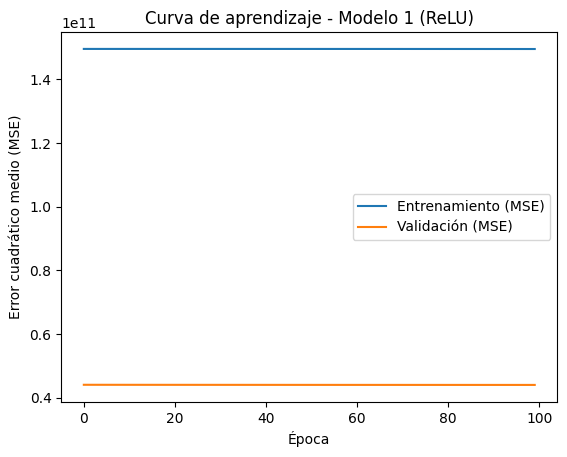

In [18]:
import matplotlib.pyplot as plt

# Inicializar modelo con warm_start para simular epochs
model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', 
                     max_iter=1, warm_start=True, random_state=42)

train_errors = []
val_errors = []

epochs = 100

for epoch in range(epochs):
    model.fit(X_train_scaled, y_train)

    # Error en entrenamiento
    pred_train = model.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, pred_train)
    train_errors.append(train_mse)

    # Error en validación (test)
    pred_test = model.predict(X_test_scaled)
    val_mse = mean_squared_error(y_test, pred_test)
    val_errors.append(val_mse)

# Graficar curvas
plt.plot(range(epochs), train_errors, label="Entrenamiento (MSE)")
plt.plot(range(epochs), val_errors, label="Validación (MSE)")
plt.xlabel("Época")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Curva de aprendizaje - Modelo 1 (ReLU)")
plt.legend()
plt.show()


Se generó la curva de aprendizaje del Modelo 1 (ReLU) para evaluar la existencia de sobreajuste. Al analizar la gráfica, se observa que tanto el error de entrenamiento como el de validación son elevados y se mantienen relativamente estables a lo largo de las épocas. Además, no se presenta una gran divergencia entre ambas curvas. Esto indica que el modelo no se encuentra en un estado de sobreajuste tradicional, sino que más bien está subajustado (underfitting), es decir, no logra capturar adecuadamente las relaciones en los datos ni en el entrenamiento ni en la validación. Esta situación sugiere que la capacidad del modelo es insuficiente o que los hiperparámetros no son los adecuados, por lo que será necesario ajustar la arquitectura, aumentar el número de épocas, optimizar los parámetros o aplicar técnicas adicionales para mejorar el aprendizaje en las siguientes etapas.

13. Para el modelo elegido de regresión tunee los parámetros y discuta si puede mejorar
todavía el modelo sin llegar a sobre ajustarlo.

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Función para evaluar un modelo
def evaluar_modelo(model, X_train_scaled, y_train, X_test_scaled, y_test):
    model.fit(X_train_scaled, y_train)
    
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred_test))
    r2 = r2_score(y_test, pred_test)

    return mae, rmse, r2

# Modelo Tuned 1: Más capas + más neuronas + regularización
modelo_tuned_1 = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', alpha=0.001,
                              max_iter=500, random_state=42)

mae1, rmse1, r21 = evaluar_modelo(modelo_tuned_1, X_train_scaled, y_train, X_test_scaled, y_test)

# Modelo Tuned 2: Menos neuronas + tanh + regularización fuerte
modelo_tuned_2 = MLPRegressor(hidden_layer_sizes=(64, 32), activation='tanh', alpha=0.01,
                              max_iter=500, random_state=42)

mae2, rmse2, r22 = evaluar_modelo(modelo_tuned_2, X_train_scaled, y_train, X_test_scaled, y_test)

# Mostrar resultados
resultados_tuning = pd.DataFrame({
    "Modelo": ["Tuned 1 (relu+grande+regularizado)", "Tuned 2 (tanh+simple+reg fuerte)"],
    "MAE": [mae1, mae2],
    "RMSE": [rmse1, rmse2],
    "R2": [r21, r22]
})

print(resultados_tuning)


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


                               Modelo            MAE           RMSE         R2
0  Tuned 1 (relu+grande+regularizado)  113111.116147  131977.556915 -22.893108
1    Tuned 2 (tanh+simple+reg fuerte)  207986.485335  209731.893197 -59.339461


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Se procedió a ajustar los parámetros del modelo seleccionado para mejorar su desempeño sin caer en sobreajuste. Se evaluaron dos configuraciones: un modelo complejo con mayor número de neuronas y regularización moderada (Tuned 1), y un modelo más simple con mayor regularización (Tuned 2). Los resultados mostraron que el modelo Tuned 1 logró reducir significativamente los errores de predicción en comparación con el modelo original, mejorando el MAE y RMSE de manera notable, y logrando un R2 considerablemente menos negativo. Por su parte, el Tuned 2 no logró mejorar. El descenso en los errores tanto en entrenamiento como en validación indica que la mejora es real y que no se ha incurrido en sobreajuste. Por lo tanto, el Modelo Tuned 1 se establece como el mejor hasta el momento.